<a href="https://colab.research.google.com/github/omersuve/Fashion-Object-Detection-Segmentation/blob/main/492_Cloth_Segmentation_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/segment.zip"

In [ ]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install -U torchmetrics

In [7]:
import os
import cv2
from torchvision import transforms as T
import torchvision


class ClothesDataset:
    def __init__(self, image_folder, mask_folder, aug_transforms):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.list_mask = sorted(os.listdir(mask_folder))
        self.list_img = sorted(os.listdir(image_folder))
       
        self.aug_transforms = aug_transforms
    
        
    def __len__(self):
        return len(self.list_img)
    
    def __getitem__(self, idx):
       
        mask = cv2.imread(os.path.join(self.mask_folder, self.list_mask[idx]), 0) # read gray scale
      
        img = cv2.imread(os.path.join(self.image_folder, self.list_img[idx])) # read bgr scale       
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert bgr to rgb
        
                
        if self.aug_transforms:
            aug = self.aug_transforms(image = img, mask=mask)
            mask = aug['mask']
            img = aug['image']
      
                 
        t = T.Compose([T.ToTensor(), T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # transforms to tensor and normalize data
        img = t(img) # transform image
        mask = torch.from_numpy(np.array(mask)).long() # convert to tensor and long data type
        
        return {'image': img, 'mask':mask}

In [9]:
import torch
import albumentations  as A
IMAGE_PATH = '/content/png_images/IMAGES'
MASK_PATH = '/content/png_masks/MASKS'
t_train = A.Compose([A.Resize(320, 224, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(320,224, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = ClothesDataset(IMAGE_PATH, MASK_PATH, t_train)
val_set = ClothesDataset(IMAGE_PATH, MASK_PATH,  t_val)

#dataloader
batch_size= 8

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

torch.Size([320, 224])


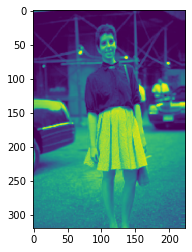

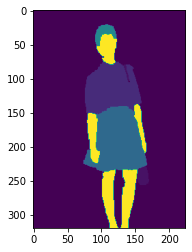

In [10]:
import matplotlib.pyplot as plt

b = val_set[30]
plt.imshow(b['image'][0])
plt.figure()
plt.imshow(b['mask'])
print(b['mask'].shape)

In [34]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchmetrics


def iou(pred, target):
    scores = []
    for cls in target.unique():       
        y_pred = pred == cls
        y_true = target == cls
        scores.append(torchmetrics.functional.jaccard_index(y_pred, y_true, num_classes=2))
    return torch.tensor(scores).mean()


class SemanticModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs)
        self.loss_fn = smp.losses.FocalLoss(mode='multiclass')
        
        self.jaccard_index = iou

    def forward(self, image):
        mask = self.model(image)    
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        mask = batch["mask"]

       
        logits_mask = self.forward(image)
        
       
        loss = self.loss_fn(logits_mask, mask)

        #pred_mask = torch.nn.functional.softmax(logits_mask, dim=1)
        pred_mask = torch.argmax(logits_mask, dim=1)
        iou_score = self.jaccard_index(pred_mask, mask.long())
        
        return {
            "loss": loss,
            "iou_score": iou_score,         
        }
    
    def shared_epoch_end(self, output_list, stage): 
        loss = torch.tensor([x['loss'].item() for x in output_list]).mean().item()
        iou_score = torch.tensor([x['iou_score'].item() for x in output_list]).mean().item()
        metrics = {
            stage+'_loss': loss,
            stage+'_iou_score': iou_score
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  
        
    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

In [35]:
model = SemanticModel("deeplabv3plus", "resnet34", in_channels=3, out_classes=59, activation=None)
print(model)

SemanticModel(
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

In [36]:
trainer = pl.Trainer(gpus=1, max_epochs=20)
print(trainer)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 22.5 M
1 | loss_fn | FocalLoss     | 0     
------------------------------------------
22.5 M    Trainable params
0         Non-trainable params
22.5 M    Total params
89.809    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [1]:
import matplotlib.pyplot as plt
b = val_set[22]
print(b['image'].shape)

device = 'cuda:0'

model.eval()
model.to(device)
logits = model(b['image'].unsqueeze(0).to(device)) # expand batch size dim
pred_mask = torch.argmax(logits, dim=1)
pred_mask = pred_mask.detach().cpu()

plt.imshow(b['mask'], cmap='inferno')
plt.figure()
plt.imshow(pred_mask[0], cmap='inferno')
print('Iou Score: ')
iou(pred_mask, b['mask'])

NameError: ignored